<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Read-in-data" data-toc-modified-id="Read-in-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Read in data</a></span></li><li><span><a href="#Examine-structure-of-DF" data-toc-modified-id="Examine-structure-of-DF-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Examine structure of DF</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Feature Engineering</a></span><ul class="toc-item"><li><span><a href="#Add-Name-Level-Features" data-toc-modified-id="Add-Name-Level-Features-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Add Name-Level Features</a></span><ul class="toc-item"><li><span><a href="#Reshaping-data" data-toc-modified-id="Reshaping-data-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Reshaping data</a></span></li><li><span><a href="#Calculating-features" data-toc-modified-id="Calculating-features-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Calculating features</a></span></li><li><span><a href="#Merging-features-to-other-tables" data-toc-modified-id="Merging-features-to-other-tables-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>Merging features to other tables</a></span></li></ul></li></ul></li><li><span><a href="#Compute-Year-Level-Features" data-toc-modified-id="Compute-Year-Level-Features-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Compute Year-Level Features</a></span></li><li><span><a href="#Analyzing-Data" data-toc-modified-id="Analyzing-Data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Analyzing Data</a></span><ul class="toc-item"><li><span><a href="#Single-Features-over-Time" data-toc-modified-id="Single-Features-over-Time-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Single Features over Time</a></span></li><li><span><a href="#Look-for-structure-in-variables" data-toc-modified-id="Look-for-structure-in-variables-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Look for structure in variables</a></span></li><li><span><a href="#Plot-Two-Features-over-Time" data-toc-modified-id="Plot-Two-Features-over-Time-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Plot Two Features over Time</a></span></li></ul></li><li><span><a href="#Uniqueness-and-The-Economy" data-toc-modified-id="Uniqueness-and-The-Economy-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Uniqueness and The Economy</a></span></li></ul></div>

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.stats import entropy
import math
import seaborn as sns
from IPython.display import display
import warnings
import syllables
import textwrap 
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Read in data

In [2]:
df = pd.read_csv("merged.csv")

# Examine structure of DF

In [3]:
# Examine structure
df.head()
display("Length: {}".format(len(df)))
display(df.columns)
display(df.dtypes)
display(df.head(5))
display(df.tail(5))

display(df.columns)

'Length: 1956907'

Index(['Unnamed: 0', 'Name', 'Gender', 'Count', 'Year'], dtype='object')

Unnamed: 0     int64
Name          object
Gender        object
Count          int64
Year           int64
dtype: object

,Unnamed: 0,Name,Gender,Count,Year
0,0,Anna,F,2604,1880
1,1,Emma,F,2003,1880
2,2,Elizabeth,F,1939,1880
3,3,Minnie,F,1746,1880
4,4,Margaret,F,1578,1880


,Unnamed: 0,Name,Gender,Count,Year
1956902,32027,Zylas,M,5,2018
1956903,32028,Zyran,M,5,2018
1956904,32029,Zyrie,M,5,2018
1956905,32030,Zyron,M,5,2018
1956906,32031,Zzyzx,M,5,2018


Index(['Unnamed: 0', 'Name', 'Gender', 'Count', 'Year'], dtype='object')

It looks like an 'Unnamed' column snuck in there so let's remove that. 

In [4]:
df = df.drop('Unnamed: 0', axis=1)
display(df.head())

,Name,Gender,Count,Year
0,Anna,F,2604,1880
1,Emma,F,2003,1880
2,Elizabeth,F,1939,1880
3,Minnie,F,1746,1880
4,Margaret,F,1578,1880


# Feature Engineering
I want to add features to track over time. In particular, let's add

- Length of name 
- Vowels in name 
- Whether name ends in vowel

## Add Name-Level Features

### Reshaping data 
The way that `df` is, observations are at the `year`X`name`X`gender` level. So there are two rows for `Jamie` in `1978` - one row for males named `Jamie` and one for females. 

Let's create a few different tables to use. 

- `no_gender` will be at the `year` X `name` level - so this table will sum name totals from `df` for a given name in a given year across genders. 
- `male` will be the names from `df` that are male names
- `female` will be the names from `df` that are female names 

Also, we have to be smart about computing features because are like 2 million rows:

- `names` will be a table that has each name just once, and various features per name (length, vowels, ends in vowel). We will compute features for names on this table, and then merge the other tables with this table so they get the name data. Otherwise, we would be doing a lot of redundant calculations since the same name shows up a lot in the other tables.  




In [5]:
# Create our tables
male = df[df['Gender']=='M'] 
female = df[df['Gender']=='F'] 
no_gender = df.groupby(by=['Year', 'Name']).sum().reset_index() 

# Name our tables
male.name = 'male'
female.name = 'female'
no_gender.name = 'no_gender'

# Put them in a list
tables = [male, female, no_gender]

### Calculating features

In [6]:
vowels = ['a', 'e', 'i', 'o', 'u']

def length(s):
    """Return length of string"""
    return len(s)

def vowel_count(s):
    """Returns number of vowels in string"""
    return len([letter for letter in s if letter in vowels])

def vowel_ending(s):
    """Returns 1 if string ends in vowel else 0"""
    if s[-1] in vowels:
        return 1
    else:
        return 0

def vowel_prop(s):
    """Returns proportion of string letters that are vowels"""
    return float(vowel_count(s)/len(s))
    
def count_syllables(s):
    """Returns syllables of a string"""
    return syllables.estimate(s)

def add_feats(s):
    """
    Returns string information in a Pandas series.
    
    Returns a string's length, vowel_count, whether ends in vowel, 
    proportion of letters that are vowels, and number of syllables. 
    
    """
    return pd.Series([
        length(s), 
        vowel_count(s), 
        vowel_ending(s), 
        vowel_prop(s),
        count_syllables(s)
])

### Merging features to other tables

In [7]:
# Get unique name values 
names = pd.DataFrame(df['Name'].unique())
names.columns = ['Name']

# Add name features to `names` table
names[[
    'length', 
    'vowel_count', 
    'vowel_ending', 
    'vowel_prop', 
    'syllables'
]] = names['Name'].apply(add_feats)
no_gender = no_gender.merge(names, on='Name', copy=False)

In [8]:
no_gender.to_csv("no_gender.csv")

# Compute Year-Level Features

In [9]:
no_gender = pd.read_csv("no_gender.csv")

In [10]:
word_feats = ['length', 'vowel_count', 'vowel_ending', 'vowel_prop', 'syllables']
years = df['Year'].unique()

def avg_col(df, value_col, count_col):
    """Computes the average of a column given values and counts"""
    avg = sum((df[count_col] * df[value_col])) / df[count_col].sum()
    return avg 

def topn_share(df, n=10):
    """Computes the fraction of values that are one of the `n` most common values"""
    df = df.sort_values(by=['Count'], ascending=False)
    topn_sum = sum(df['Count'].tolist()[:n])
    total_sum = df['Count'].sum()
    topn_share = topn_sum/total_sum
    return topn_share

def churn_rate(master_df, current_df, year, n=10):
    """Computes the churn rate between top values in two periods"""
    current_df = current_df.sort_values(by=['Count'], ascending=False)
    current_topn = set(current_df.head(n)['Name'].tolist())
    if year > 1880:
        past_df = master_df[master_df['Year'] == year-1]
        past_df = past_df.sort_values(by=['Count'], ascending=False)
        past_topn = set(past_df.head(n)['Name'].tolist())
        overlap = len(current_topn.intersection(past_topn))
        churn = 1 - overlap/n
        return churn
    else:
        return np.NaN
    
def prob_2(df):
    """Computes the probability 2 random names are the same"""
    s = df['Count'].values
    n = s.sum()
    prob = np.sum(s/n * (s-1)/(n-1))
    return prob

def compute_entropy(df):
    """Computes Shannon entropy of names in a given year"""
    n = df['Count'].sum()
    ent = entropy(df[['Name', 'Count']].set_index('Name').squeeze(), base=2)
    ent = ent / math.log(n, 2)
    
    return ent
        
def yearly_data(df, year):
    """Computes all the above metrics for a year"""
    temp_df = df[df['Year'] == year]
    data = {
        "Year": year,
        "top10_share": topn_share(temp_df, 10), 
        "top20_share": topn_share(temp_df, 20),
        "top50_share": topn_share(temp_df, 50),
        "prob_2": prob_2(temp_df), 
        "ent": compute_entropy(temp_df),
        "churn_rate": churn_rate(df, temp_df, year, 100),
        'length': avg_col(temp_df, 'length', 'Count'),
        'vowel_count': avg_col(temp_df, 'vowel_count', 'Count'),
        'vowel_ending': avg_col(temp_df, 'vowel_ending', 'Count'),
        'vowel_prop': avg_col(temp_df, 'vowel_prop', 'Count'),
        'syllables': avg_col(temp_df, 'syllables', 'Count'),
    }
    return data

df = pd.DataFrame([yearly_data(no_gender, year) for year in years])

# Analyzing Data

In [11]:
# First, I want to create some clean labels for all these variables.

def wrap_text(s, wrap_len=50):
    wrapper = textwrap.TextWrapper(width=wrap_len)
    return wrapper.wrap(text=s)

label_dict = {}
label_dict = {
    'Year': "Year",
    "top20_share": "Prop. of Americans with name in top 20 names", 
    "top10_share": "Prop. of Americans with name in top 10 names", 
    "top50_share":"Prop. of Americans with name in top 50 names",
    'prob_2': "Prob. 2 random Americans have same name", 
    'ent': 'Entropy of names',
    'churn_rate': "Churn rate of top 10 names",
    "length": 'Avg Length of names',
    'vowel_count': "Avg count of vowels in name",
    'vowel_ending': 'Avg prop names end in vowel',
    'vowel_prop': 'Avg proportion of name that is vowels',
    'syllables': 'Avg number of syllables in name'
}

## Single Features over Time

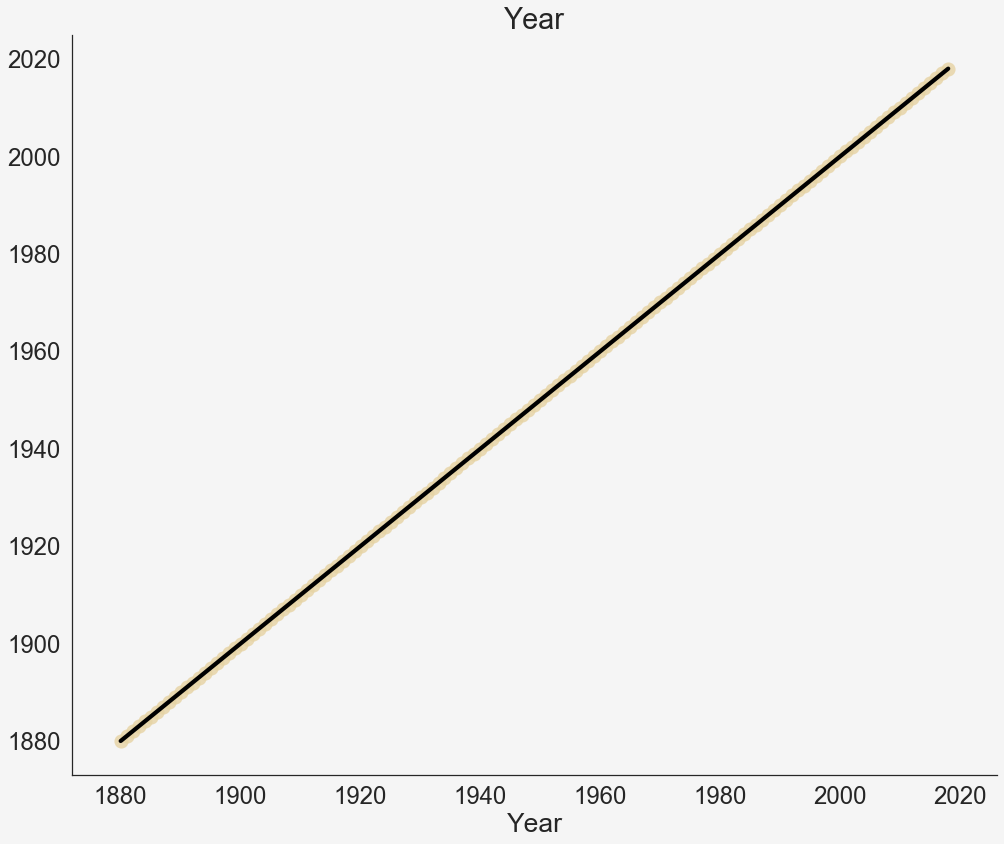

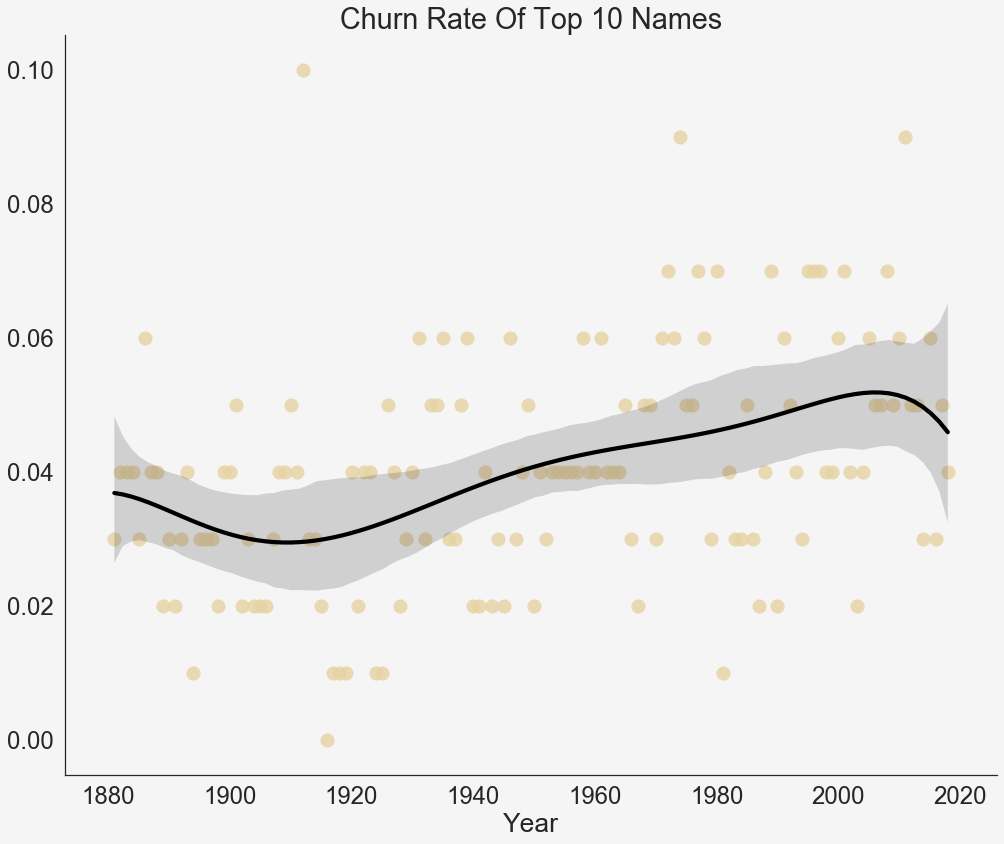

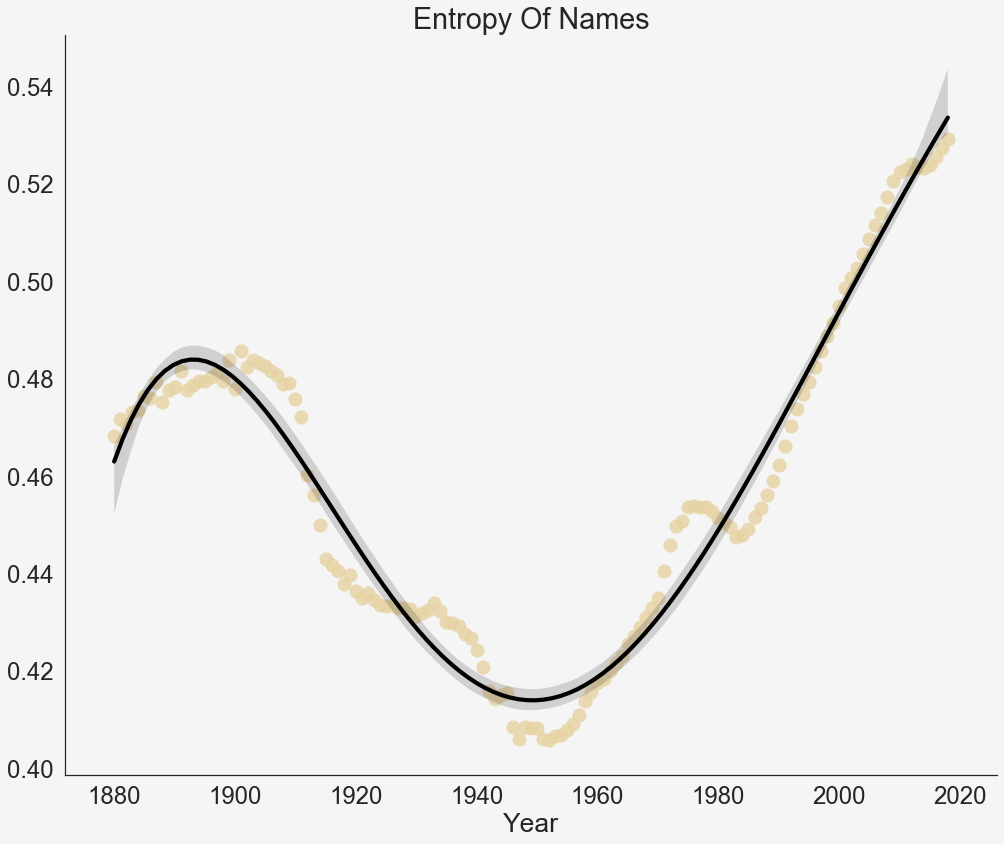

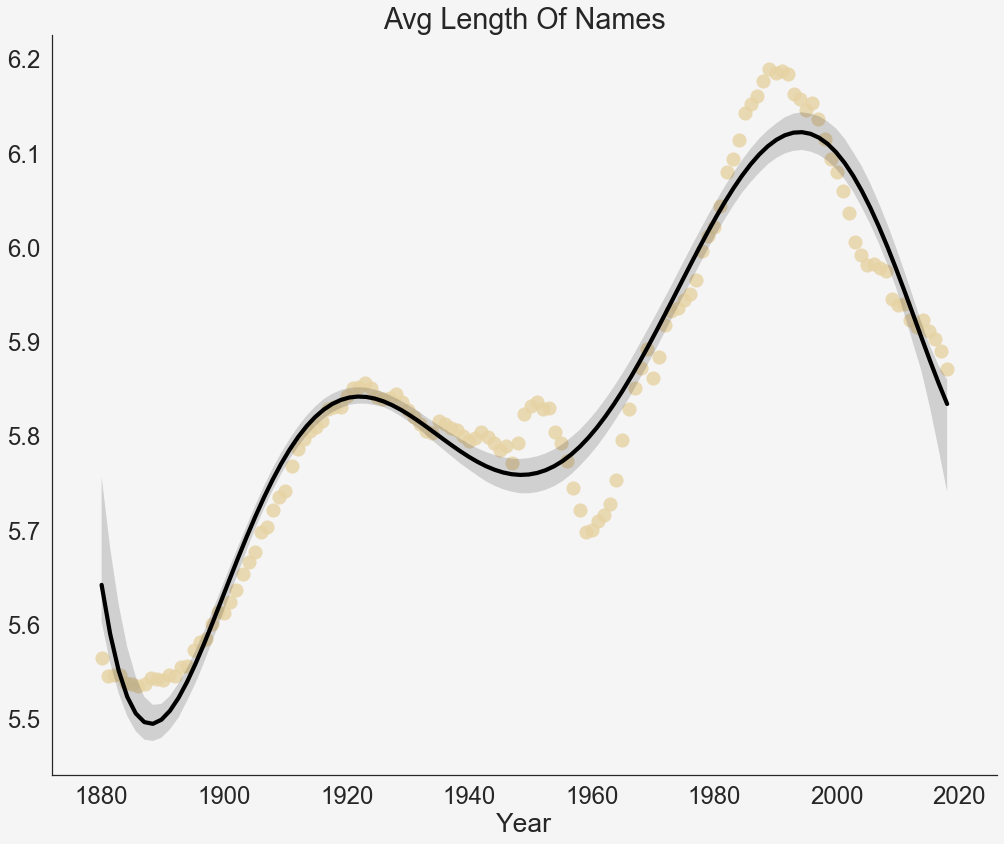

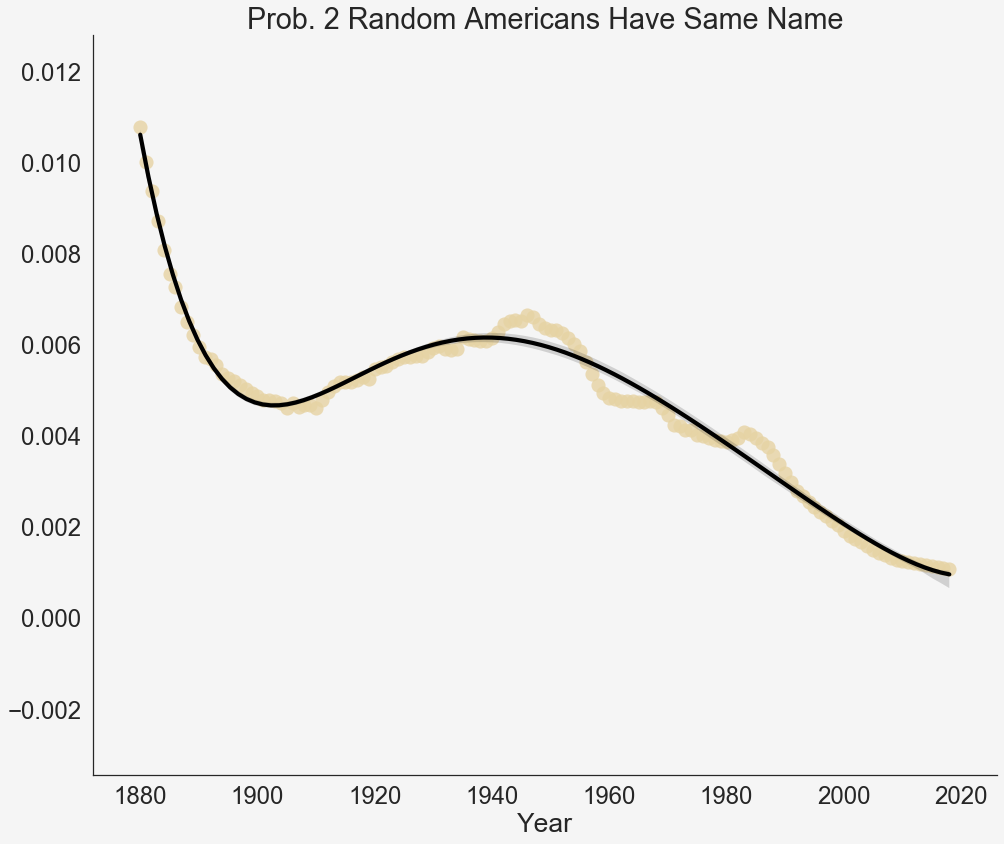

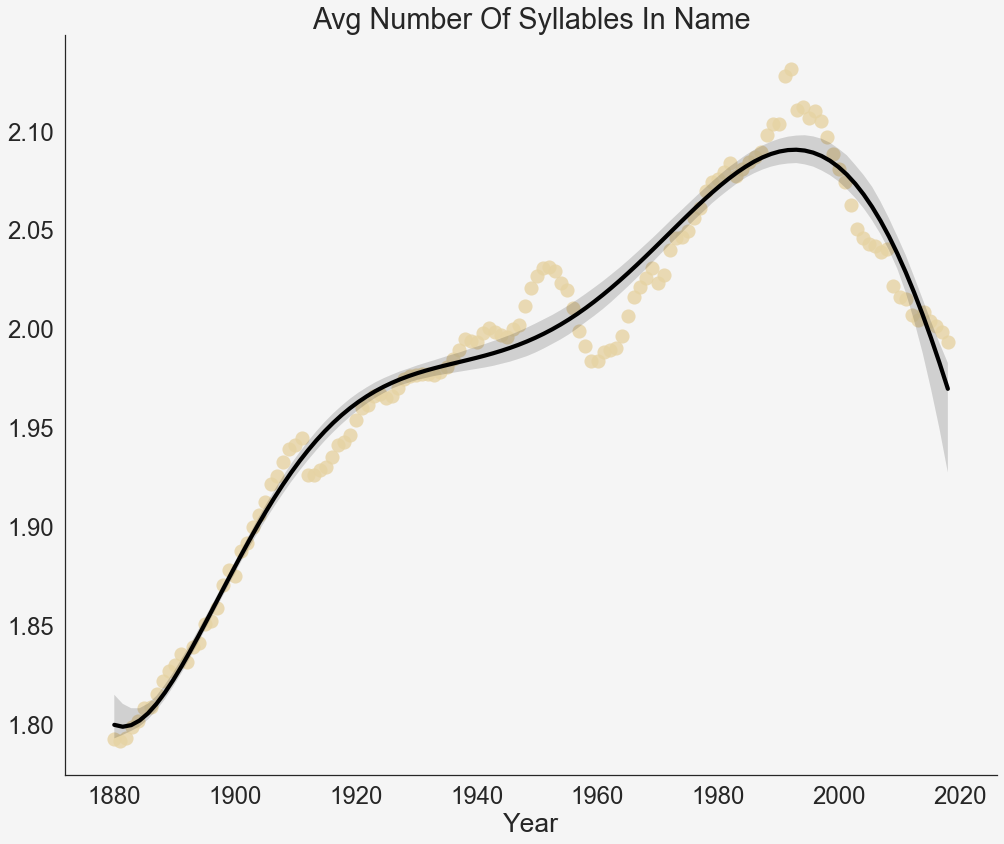

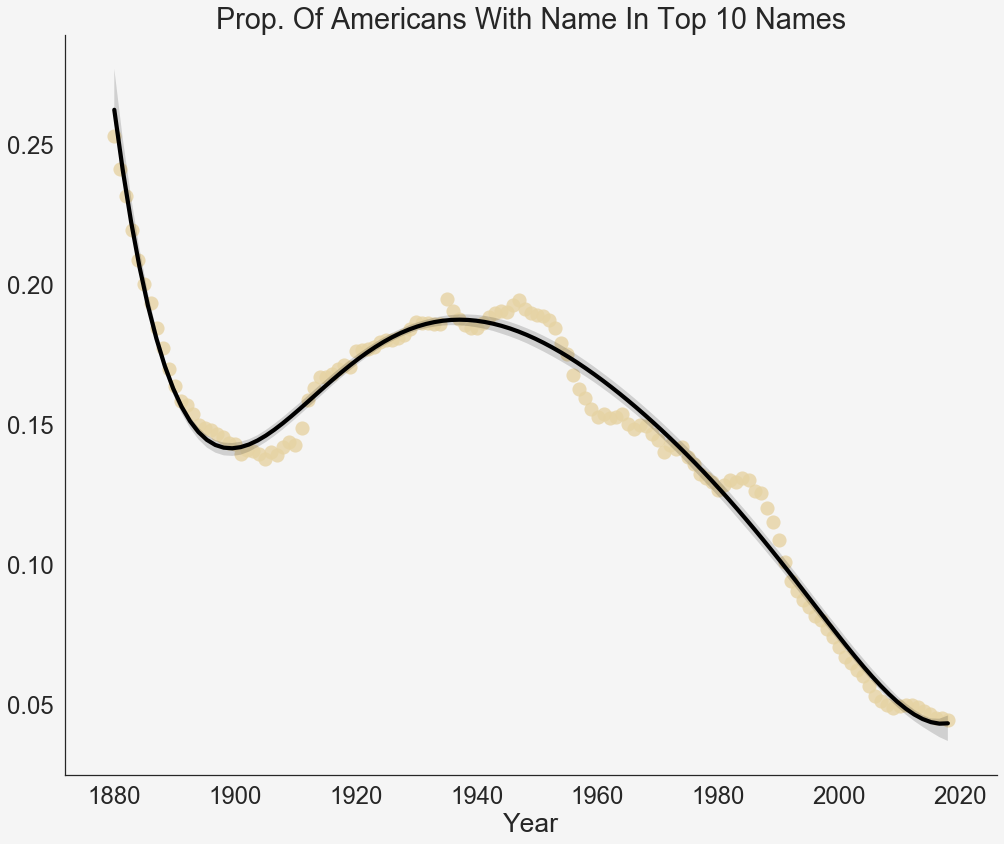

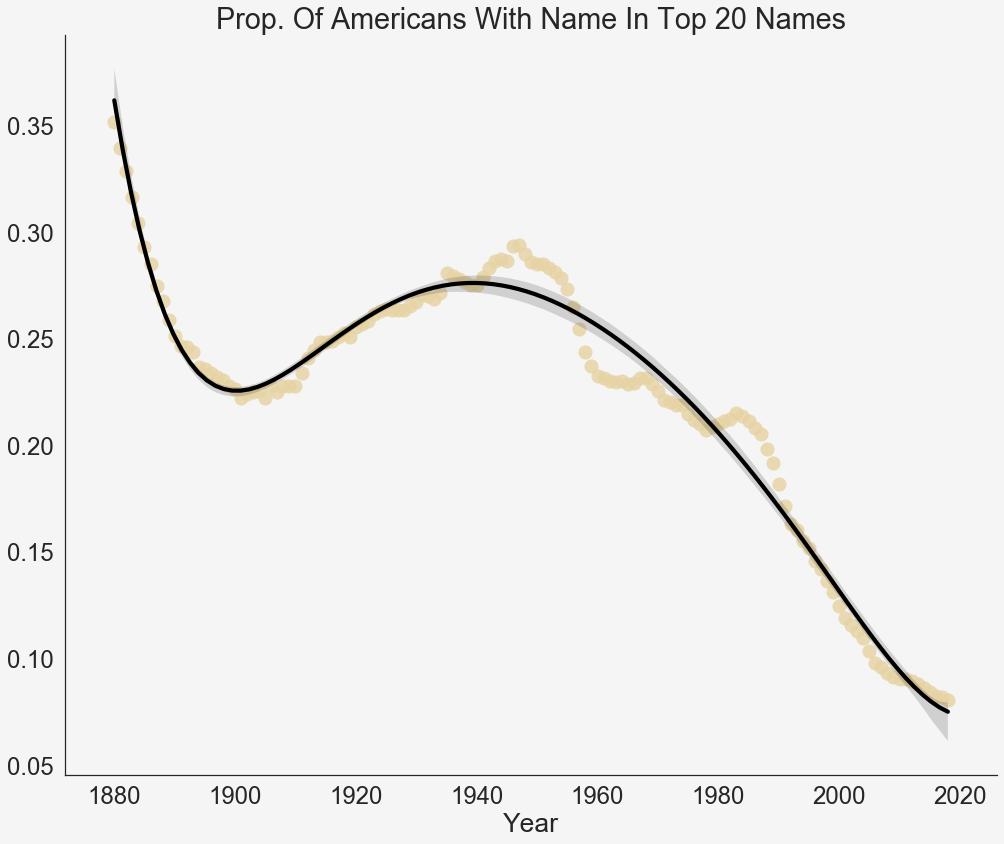

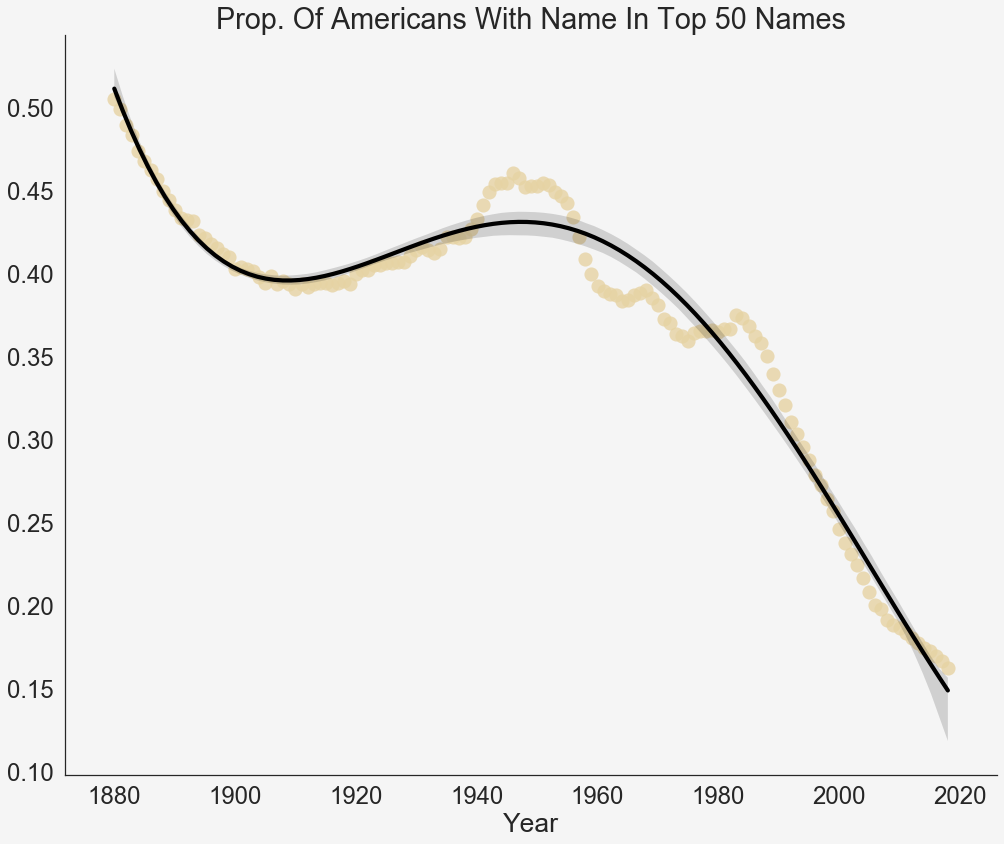

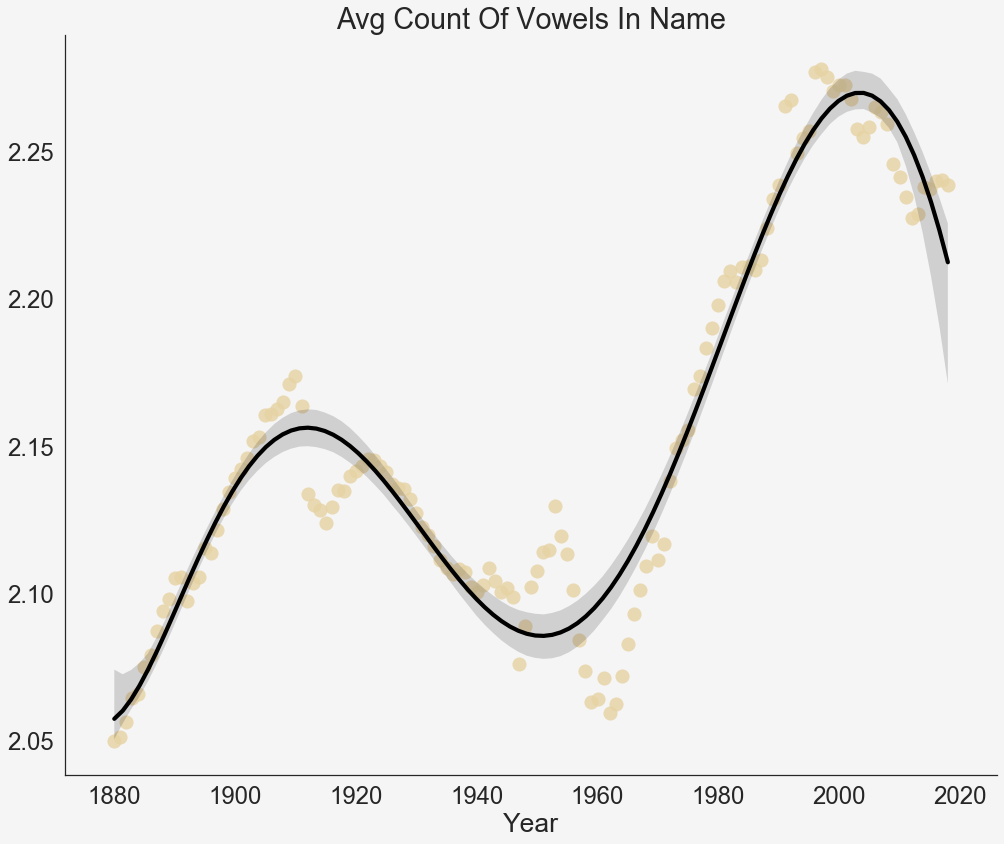

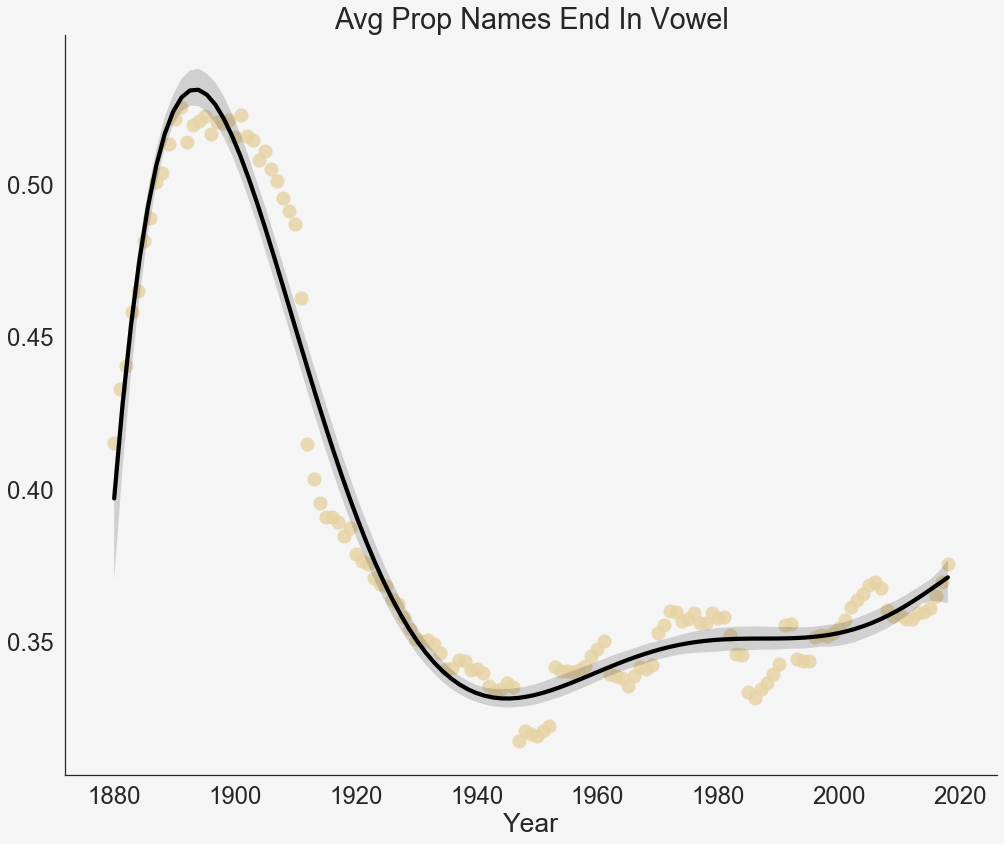

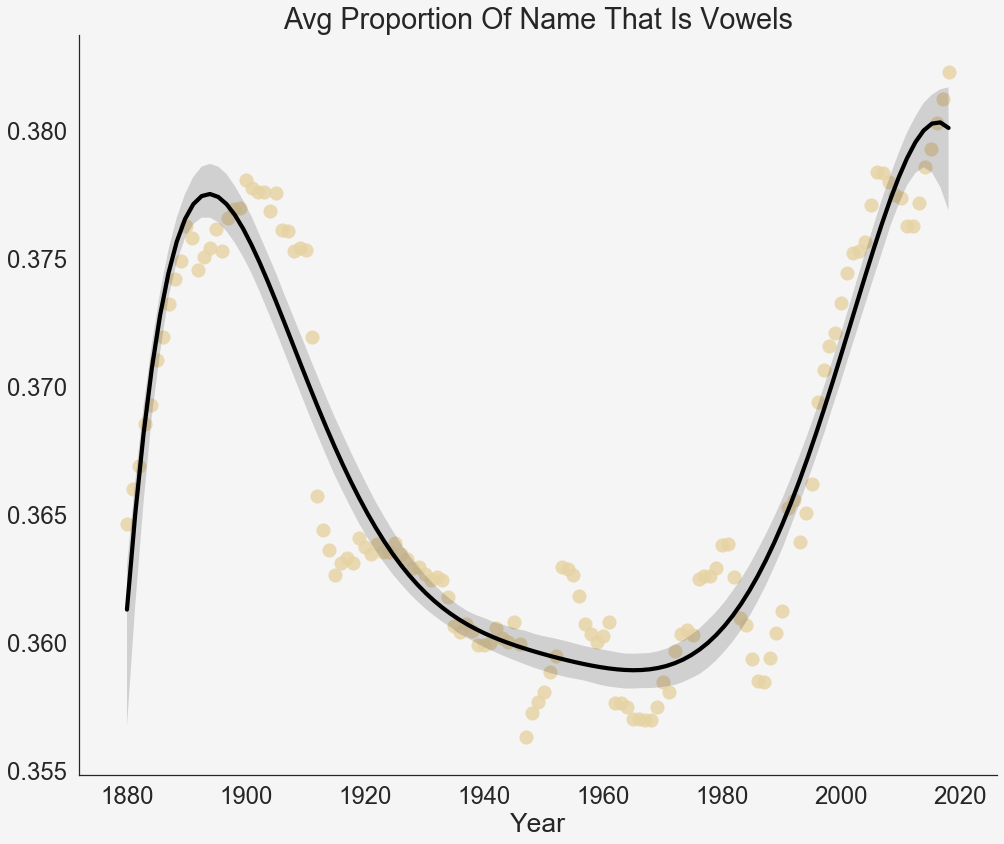

In [12]:
sns.set(
        style='white',
        context="poster", 
        font_scale=1.5,
        rc={
            'axes.facecolor':'#f5f5f5', 
            'figure.facecolor':'#f5f5f5'
    }
)

def line_plot(df, var, ytitle, order=1, date_range=[1800, 3000]):
    allowed_dates = [i for i in range(date_range[0], date_range[1])]
    g = sns.lmplot(data=df[df['Year'].isin(allowed_dates)], 
               x='Year', 
               y=var ,
               aspect=15/12, 
               scatter=True, 
               size=12, 
               truncate=True, 
                fit_reg=True,
                order=6,
               line_kws={'color': 'Black'}, 
               scatter_kws ={'color': '#E6D3A3', 's':200}
              )
    ax = plt.gca()
    ax.set(title=label_dict[var].title(), ylabel="")

    plt.show()
    
for c in df.columns:
    line_plot(df, c, c.replace("-", ""))

## Look for structure in variables

I want to make sure that the variables measuring uniqueness hang together (though of course, higher entropy should mean lower values for the other uniqueness variables). 

I also want to see what feature variables correlated with uniqueness. In other words, as names are getting more unique, what is happening to them? 

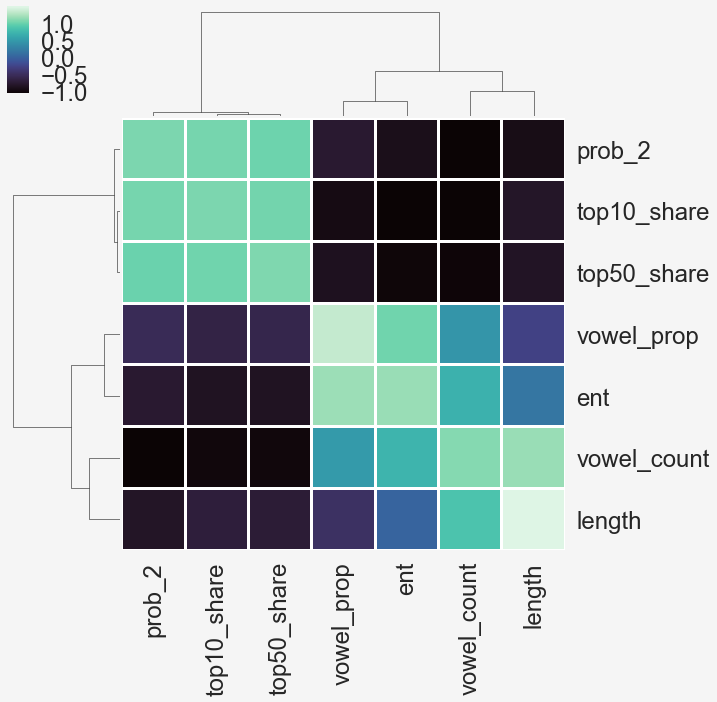

In [14]:
feats = df[['Year', 'prob_2', 'vowel_count', 'length', 'vowel_prop', 'top10_share', 'top50_share', 'ent']]
feats = feats.set_index('Year')
sns.clustermap(feats.corr(), z_score=1, cmap='mako', linewidths=2)

## Plot Two Features over Time

I want to look at `Prob_2` and `vowel_prop` as well as `length`. It looks like as `Prob_2` declines, the other two increase. 

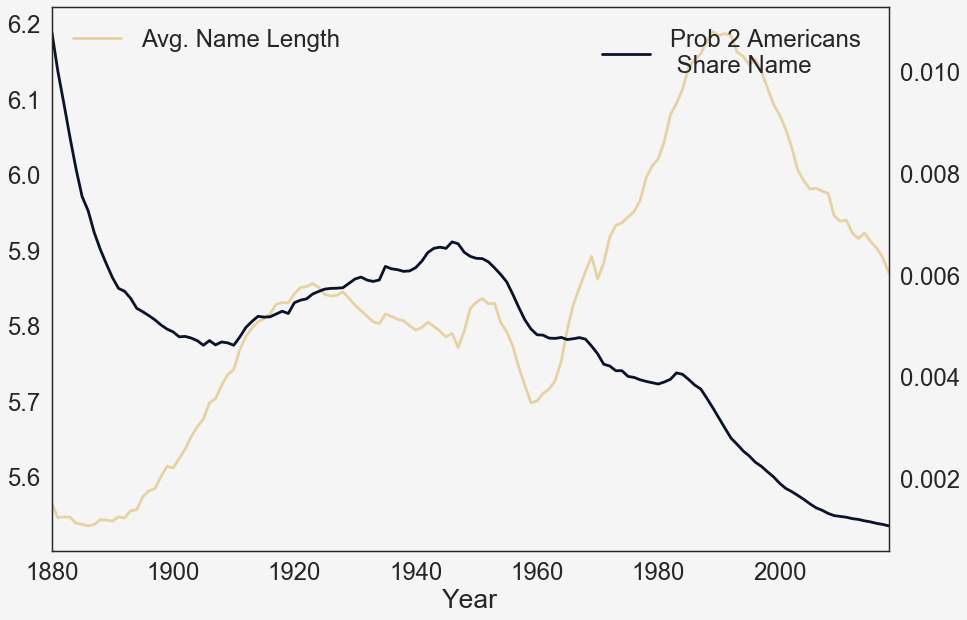

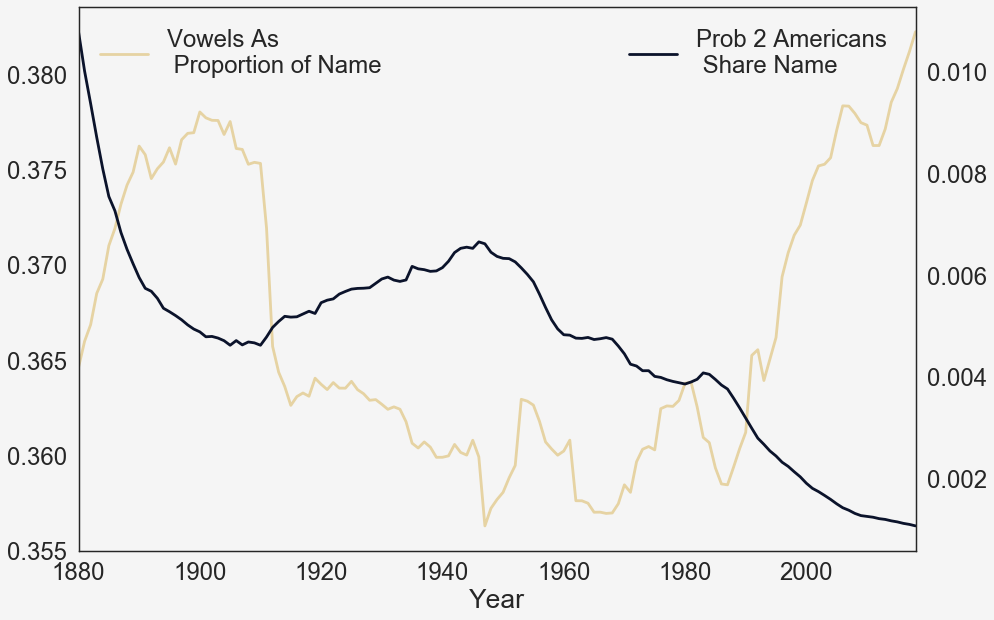

In [15]:

def two_features_plot(df, feat1, feat2, label1=None, label2=None):
    df.reset_index()
    ax = df.plot(x="Year", y=feat1, color='#E6D3A3', legend=True, label=label1)
    ax2 = ax.twinx()
    df.plot(x="Year", y=feat2, label=label2, ax=ax2, legend=True, color="#0B132B", figsize=(15, 10))
    
two_features_plot(df, "length", "prob_2", "Avg. Name Length", 'Prob 2 Americans \n Share Name')
two_features_plot(df, "vowel_prop", "prob_2", "Vowels As\n Proportion of Name", 'Prob 2 Americans \n Share Name')

# Uniqueness and The Economy

Let's see if GDP growth looks to be related to uniqueness. (I think it is!)

In [16]:
# Get a series on GDP Change from FRED; merge this with yearly name features df

pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import datetime
start = datetime.datetime(1900, 1, 1)
end = datetime.datetime(2019, 1, 27)
gdp = web.DataReader("A191RL1A225NBEA", "fred", start, end)
gdp.index= pd.DatetimeIndex(gdp.index).year
gdp = gdp.reset_index()
gdp.columns = ['Date', 'GDP Change']
m = df.merge(gdp, left_on='Year', right_on='Date')

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

def performance(x):
    if x <= 0:
        return "Contraction"
    elif x > 0 :
        return "Growth"
    
m['perform']=m['GDP Change'].apply(lambda x: performance(x))
display(m.groupby(by=['perform']).mean())

for var in m[['prob_2', 'top10_share', 'top50_share', 'top20_share', 'ent']].columns:
    cat1 = m[m['perform']== 'Contraction']
    cat2 = m[m['perform']== 'Growth']
    print("ttest for {}:".format(var), ttest_ind(cat1[var], cat2[var], equal_var=False))
    
plt.figure(figsize=(15, 12))   
sns.pointplot(data=m, y='top10_share',x='perform', ci=True)
plt.suptitle("Prop. Americans Who Have Name in Top 10 Names")
plt.title("In economic contractions, American names become less unique.")
sns.despine()
plt.ylabel("")
plt.xlabel("Economic Performance \n (Contraction is <0% GDP Change;  Growth is >=0% GDP Change)")


At a 5% significance level: 
    `Prob_2` is lower for contractions relative to growth periods. 
    `top10_share`...`top50_share` is lower for contractions relative to growth periods. 
    There is no evidence to reject the null that entropy is the same for both contractions and growth periods. 